**Context**   
Predict behavior to retain customers.   
The dataset was obtained from Telco Customer Churn on Kaggle (https://www.kaggle.com/blastchar/telco-customer-churn).

**Content**  
Each row represents a customer, each column contains customer’s attributes.

In [1]:
# importing some of the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [31]:
df = pd.read_csv('archive.zip')

In [32]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

There are **7043 rows** and **21 columns** (20 features and 1 target variable).  
Also, all the features are categorical except: **SeniorCitizen**, **tenure** and **MonthlyCharges**.  
The **TotalCharges** is not numerical, surprisingly.

In [34]:
# Changing the TotalCharges feature from categorical to numerical.
# After emplimenting pd.to_numeric, 11 instances turned out to have Nan value, which I fill them with the column mean value.

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
df['TotalCharges'].fillna(value=df['TotalCharges'].mean(),inplace=True)

# checking if there is any null values left
df['TotalCharges'].isnull().sum()

0

Let's **explore the categorical features** and their unique values:

In [35]:
columns_cat = df.select_dtypes(include='object').columns
for column in columns_cat:
    print(f"The unique values for {column} are {df[column].unique()}, and the number of unique values is {df[column].nunique()}\n")

The unique values for customerID are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'], and the number of unique values is 7043

The unique values for gender are ['Female' 'Male'], and the number of unique values is 2

The unique values for Partner are ['Yes' 'No'], and the number of unique values is 2

The unique values for Dependents are ['No' 'Yes'], and the number of unique values is 2

The unique values for PhoneService are ['No' 'Yes'], and the number of unique values is 2

The unique values for MultipleLines are ['No phone service' 'No' 'Yes'], and the number of unique values is 3

The unique values for InternetService are ['DSL' 'Fiber optic' 'No'], and the number of unique values is 3

The unique values for OnlineSecurity are ['No' 'Yes' 'No internet service'], and the number of unique values is 3

The unique values for OnlineBackup are ['Yes' 'No' 'No internet service'], and the number of unique values is 3

The unique values for DeviceProte

In [36]:
# A few of the columns has the value "No internet service" as a separate value. No need for that!

temp_columns = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for c in temp_columns:
    df[c] = df[c].replace({'No internet service':'No'})

In [37]:
# same thing with MultipleLines column, which has the No phone service and No

df['MultipleLines'] = df['MultipleLines'].replace({'No phone service':'No'})

What about **SeniorCitizen**? first let's convert the numerical value to categorical value using .map

In [38]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({0:'No',1:'Yes'})

Let's take a look at the numerical features and their distribution.

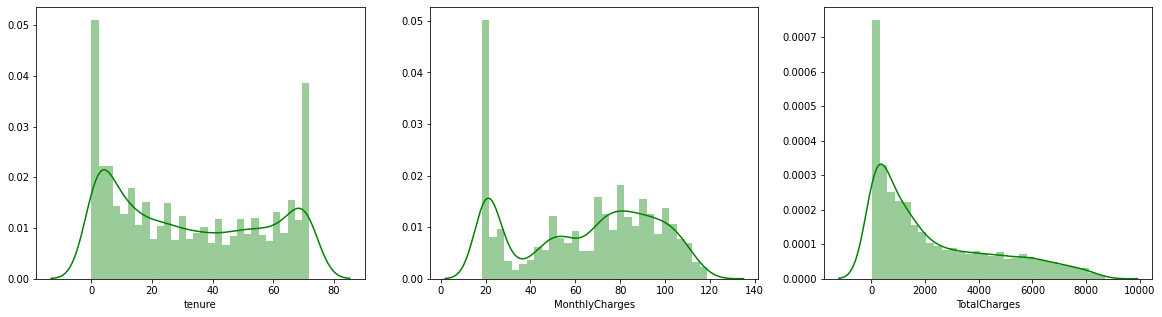

In [39]:
columns_numerical = df.select_dtypes(exclude='object').columns.tolist()
plt.figure(figsize=(20,5))
for i,column in enumerate(columns_numerical,1):
    plt.subplot(1,3,i)
    sns.distplot(df[column],color='green',bins=30)

Many machine learning algorithms perform better when the distribution of variables is Gaussian. Another common reason for transformations is to remove distributional skewness. TotalCharges is an obvious example of highly skewed distribution (right skewed). One way to address this issue is by using PowerTransformers, two famous methods are: **Box-Cox Transform** & **Yeo-Johnson Transform**.  
**Box-Cox Transform** is a power transform that assumes the values of the input variable to which it is applied are **strictly positive**. That means 0 and negative values are not supported. To solve the 0 and negative value problem, we can use a MixMaxScaler transform first to scale the data to positive values, then apply the transform.

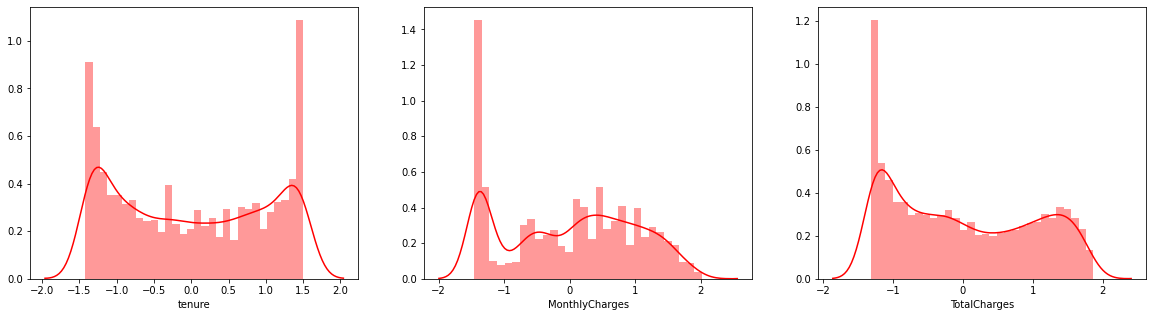

In [40]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(20,5))
for i,column in enumerate(columns_numerical,1):
    scaler = StandardScaler()
    power = PowerTransformer(method='yeo-johnson')
    pipeline = make_pipeline(scaler,power)
    temp = pipeline.fit_transform(df[column].to_numpy().reshape(-1, 1))
    plt.subplot(1,3,i)
    sns.distplot(temp,color='red',bins=30, axlabel=column)

In [41]:
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson')
pipeline = make_pipeline(scaler,power)
df[columns_numerical]  = pd.DataFrame(pipeline.fit_transform(df[columns_numerical].to_numpy()),columns=columns_numerical)

In [42]:
# customerID does not seem to provide a valuable insight, let's just drop it!

df.drop('customerID', axis=1, inplace=True)

In [43]:
# since there is no ordinal categorical feature, I will use pd.get_dummies to convert all categorical features to numerical.

df_dummies = pd.get_dummies(df, drop_first=True)

In [44]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
tenure                                   7043 non-null float64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
gender_Male                              7043 non-null uint8
SeniorCitizen_Yes                        7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
PhoneService_Yes                         7043 non-null uint8
MultipleLines_Yes                        7043 non-null uint8
InternetService_Fiber optic              7043 non-null uint8
InternetService_No                       7043 non-null uint8
OnlineSecurity_Yes                       7043 non-null uint8
OnlineBackup_Yes                         7043 non-null uint8
DeviceProtection_Yes                     7043 non-null uint8
TechSupport_Yes                  

**Let's explore the target variable now and its correlation with other features.**

In [45]:
df_dummies['Churn_Yes'].value_counts()

0    5174
1    1869
Name: Churn_Yes, dtype: int64

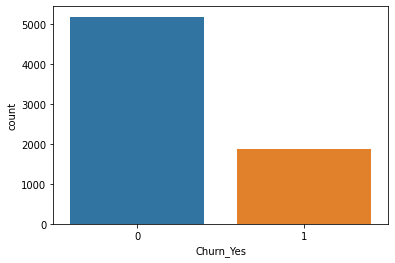

In [46]:
sns.countplot(x=df_dummies['Churn_Yes'], data=df)

In [47]:
# Percentage of Churned customers in the dataset

churned_rate = round(df_dummies['Churn_Yes'].value_counts()[1]*100/len(df_dummies),2)
print(f'The churn rate in the dataset is {churned_rate}%')

The churn rate in the dataset is 26.54%


**The target variable is noticeably imbalanced, something to consider when we get to the model training step.  
And now let's look at the correlations between Churn and other features.**

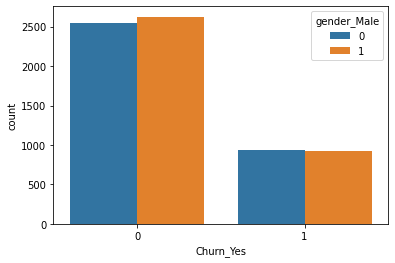

In [48]:
sns.countplot(x=df_dummies['Churn_Yes'],data=df_dummies,hue='gender_Male')

**As shown above, gender does not show a meaningful correlation with churn rate.**

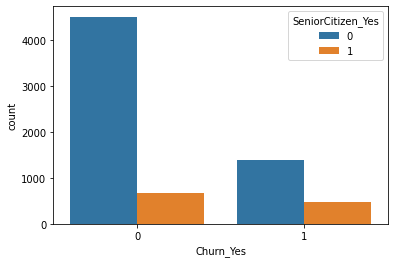

In [49]:
sns.countplot(x=df_dummies['Churn_Yes'],data=df_dummies,hue='SeniorCitizen_Yes')

**Obviously, the ratio of the Senior Citizens is higher in the Churned customers compare to loyal customers.**

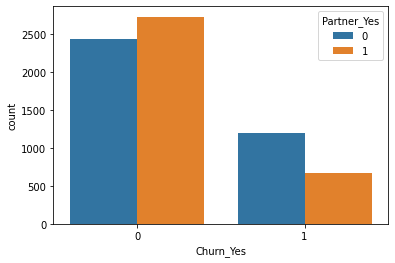

In [50]:
sns.countplot(x=df_dummies['Churn_Yes'],data=df_dummies,hue='Partner_Yes')

**It looks like people who don’t have partner are more likely to churn!**

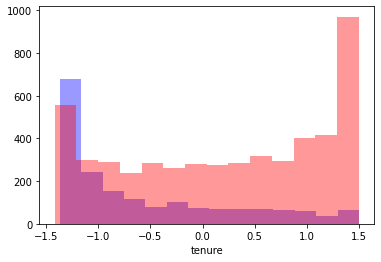

In [51]:
tenure_churned = df_dummies[df_dummies['Churn_Yes']==1]['tenure']
tenure_Notchurned = df_dummies[df_dummies['Churn_Yes']==0]['tenure']
sns.distplot(tenure_churned,kde=False,color='blue')
sns.distplot(tenure_Notchurned,kde=False,color='red')

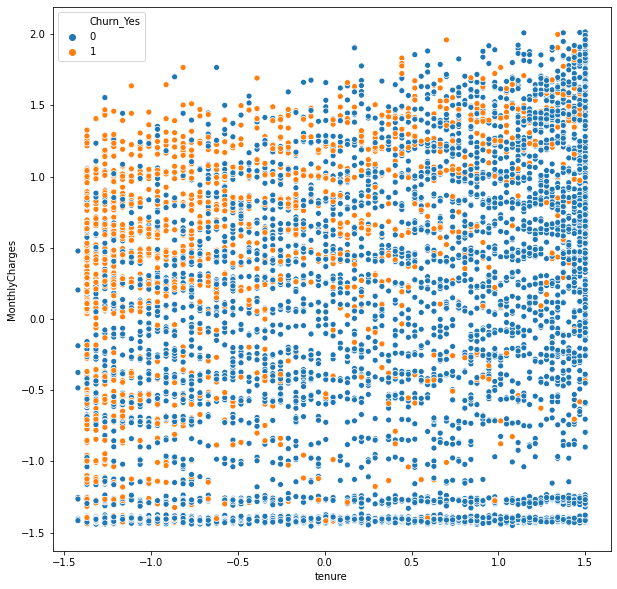

In [52]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='tenure',y='MonthlyCharges',data=df_dummies,hue='Churn_Yes')

**The heatmap below illustrates the correlations between all the features.**

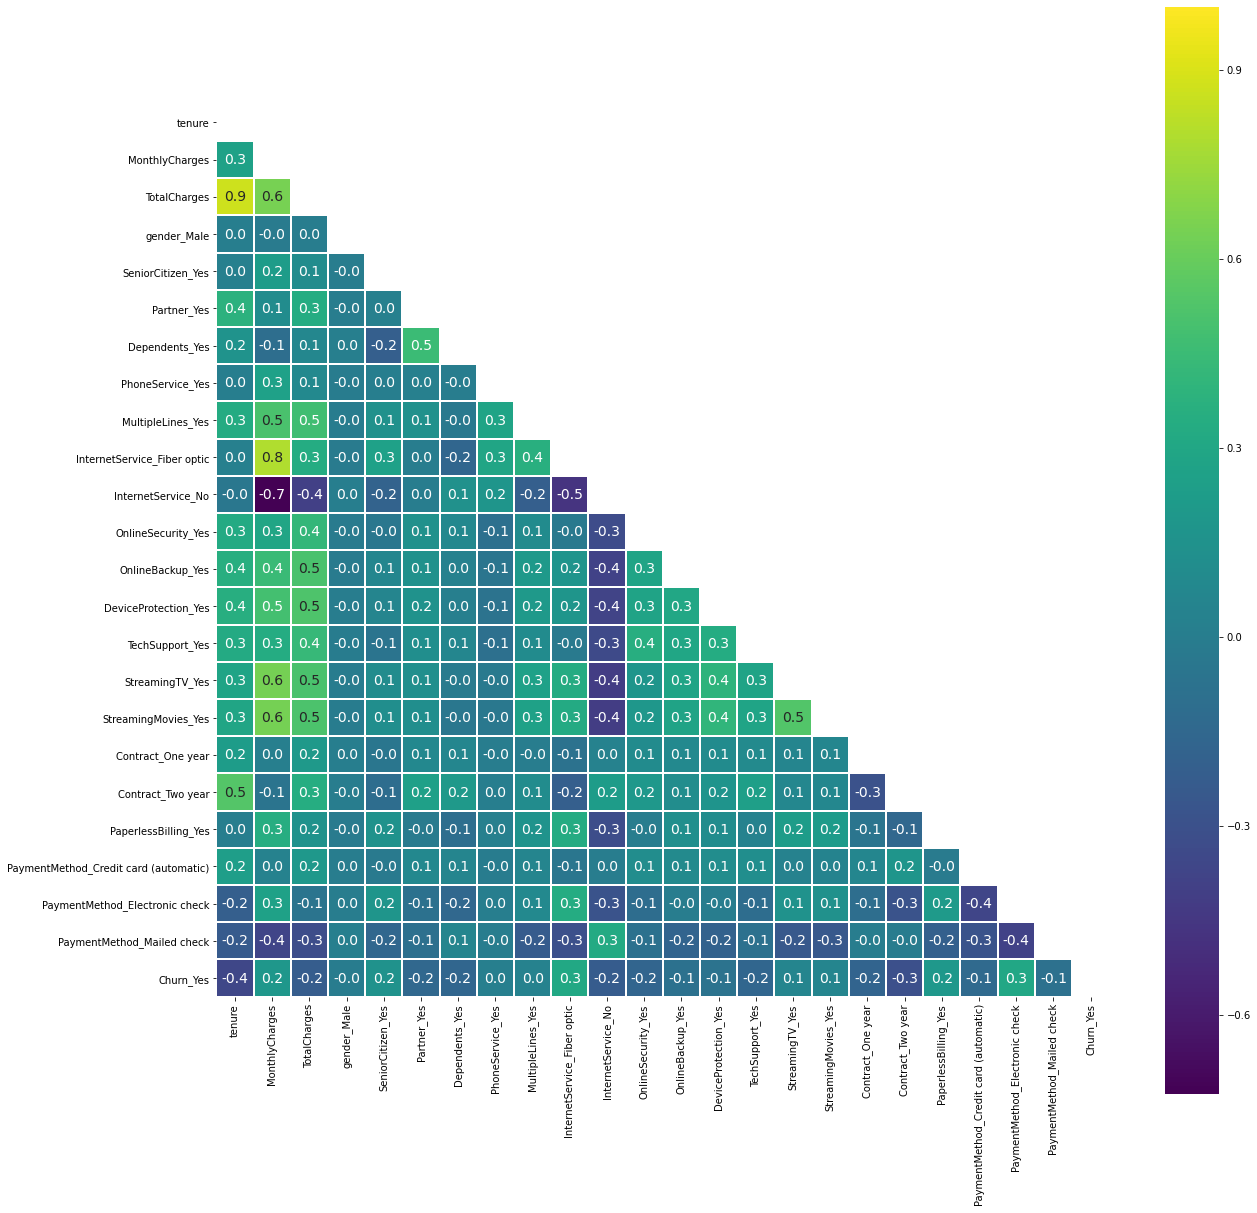

In [53]:
plt.figure(figsize=(20,20))
mask = np.zeros_like(df_dummies.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df_dummies.corr(),annot=True,square=True,linewidths=1,mask=mask,fmt=".1f",annot_kws={'size':14},cmap='viridis')

The barplot below only shows the correlations between the Churn and the other features. 

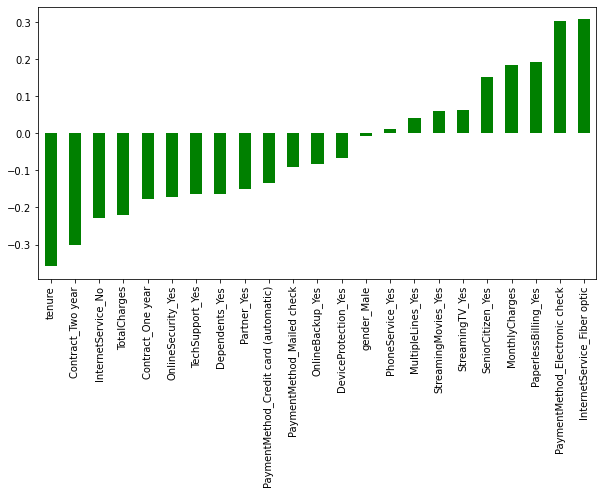

In [54]:
plt.figure(figsize=(10,5))
df_dummies.corr()['Churn_Yes'].sort_values()[:-1].plot.bar(color='green')

# Modeling

First let's separate the features and the target variable, and convert them into Numpy arrays

In [64]:
X = df_dummies.drop('Churn_Yes',axis=1).values
y = df_dummies['Churn_Yes'].values

As mentioned earlier in the EDA (Exploratory Data Analysis) step, the target variable is considerably imbalanced (73.44% vs 26.54%). This means if a model assigns all the predictions to the majority class, it will reach **73.44% accuracy**, which is the **minimum accuracy score** that we need to achieve. Although, in this case, the accuracy score is not the best metric for the performance comparison. **ROC-AUC** would be a better measurement to look at. 

Most machine learning algorithms ignore the imbalanced distributions and perform poorly specially on the minority class which is normally the class of interest. One approach to address this issue is to produce or synthetize more data points for the minority class, which is know as **data augmentation**. One of the most famous data augmentation technique is **SMOTE** (Synthetic Minority Oversampling Technique) which synthesizes new examples for the minority class. We use **Imbalanced-Learn library** to instantiate an SMOTE’s instance.   
The way SMOTE algorithm works is by choosing a random instance of the minority class. Then, it finds the K nearest minority class neighbors, followed by choosing one of them at random. Afterwards, it draws a line between the two point in the feature space and select a point, again at random, on the line and add to the minority class. It is noteworthy to mention that **the original paper on SMOTE** recommended combining SMOTE with **random undersampling** of the majority class, which is also supported in the imbalanced-learn library.  

There are different extensions to SMOTE to synthesize samples more selectively, to call a few: **Borderline-SMOTE and Borderline-SMOTE SVM** which I will try to evaluate and compare their performance. Moreover, another approach is called **ADASYN** (Adaptive Synthetic Sampling) which generate samples based on inverse proportion of the density of the examples in the minority class.


In [86]:
import imblearn

In [109]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score,roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [115]:
# instanciating the models which I am going to use

lr = LogisticRegression()
svc_linear = SVC(kernel='linear')
svc_rbf = SVC(kernel='rbf')
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()

In [199]:
# Grid search SMOTE K value
k_values = [1,2,3,4,5,6,7,8,9,10]

models = [('LogisticRegression',lr),('SVC_Linear',svc_linear),('SVC_rbf',svc_rbf),('DecisionTreeClassifier',dtc),('RandomForestClassifier',rfc),('AdaBoostClassifier',ada),('XGBClassifier',xgb)]

I will calculate and record **two scoring metrics (Accuracy and ROC_AUC)** as shown in the cell below.

In [116]:
# SMOTE Oversampling

results_SMOTE = []
for name,model in models:
    for k in k_values:
        model = model
        over = SMOTE(k_neighbors=k)
        under = RandomUnderSampler()
        pipeline = make_pipeline(over, under, model)
        cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scoring = {'acc':'accuracy', 'auc':'roc_auc'}
        scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        accuracy = round(scores['test_acc'].mean(),5)
        accuracy_std = round(scores['test_acc'].std(),5)
        auc = round(scores['test_auc'].mean(),5)
        auc_std = round(scores['test_auc'].std(),5)
        results_SMOTE.append((name,k,accuracy,accuracy_std,auc,auc_std))
        print(f'For {name}, SMOTE K value of {k:2}, accuracy is {accuracy:6} and ROC_AUC is {auc:6}')
    print('\n')

For LogisticRegression, SMOTE K value of  1, accuracy is 0.75488 and ROC_AUC is 0.8446
For LogisticRegression, SMOTE K value of  2, accuracy is 0.75554 and ROC_AUC is 0.84452
For LogisticRegression, SMOTE K value of  3, accuracy is 0.75507 and ROC_AUC is 0.84453
For LogisticRegression, SMOTE K value of  4, accuracy is 0.75469 and ROC_AUC is 0.84452
For LogisticRegression, SMOTE K value of  5, accuracy is 0.75512 and ROC_AUC is 0.84462
For LogisticRegression, SMOTE K value of  6, accuracy is 0.75479 and ROC_AUC is 0.84454
For LogisticRegression, SMOTE K value of  7, accuracy is 0.75559 and ROC_AUC is 0.84456
For LogisticRegression, SMOTE K value of  8, accuracy is 0.75512 and ROC_AUC is 0.84473
For LogisticRegression, SMOTE K value of  9, accuracy is 0.75678 and ROC_AUC is 0.84459
For LogisticRegression, SMOTE K value of 10, accuracy is 0.75521 and ROC_AUC is 0.84446


For SVC_Linear, SMOTE K value of  1, accuracy is  0.706 and ROC_AUC is 0.83982
For SVC_Linear, SMOTE K value of  2, acc

In [118]:
results_SMOTE_df = pd.DataFrame(results_SMOTE, columns=['Model','K_Value','Accuracy','Accuracy_STD','ROC_AUC','ROC_AUC_STD'])
results_SMOTE_df['Oversampler'] = 'SMOTE'

In [133]:
results_SMOTE_df.head()

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
0,LogisticRegression,1,0.75488,0.01473,0.84460,0.01491,SMOTE
1,LogisticRegression,2,0.75554,0.01510,0.84452,0.01471,SMOTE
2,LogisticRegression,3,0.75507,0.01476,0.84453,0.01460,SMOTE
3,LogisticRegression,4,0.75469,0.01496,0.84452,0.01484,SMOTE
4,LogisticRegression,5,0.75512,0.01529,0.84462,0.01457,SMOTE


In [125]:
max_accuracy_SMOTE = results_SMOTE_df[results_SMOTE_df['Accuracy']==results_SMOTE_df['Accuracy'].max()]
max_accuracy_SMOTE

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,oversampler
69,XGBClassifier,10,0.78801,0.01458,0.84678,0.01371,SMOTE


In [126]:
max_ROC_AUC_SMOTE = results_SMOTE_df[results_SMOTE_df['ROC_AUC']==results_SMOTE_df['ROC_AUC'].max()]
max_ROC_AUC_SMOTE

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,oversampler
63,XGBClassifier,4,0.78262,0.01339,0.84715,0.01403,SMOTE


In [122]:
# BorderlineSMOTE Oversampling

results_BorderlineSMOTE = []
for name,model in models:
    for k in k_values:
        model = model
        over = BorderlineSMOTE(k_neighbors=k)
        under = RandomUnderSampler()
        pipeline = make_pipeline(over, under, model)
        cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scoring = {'acc':'accuracy', 'auc':'roc_auc'}
        scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        accuracy = round(scores['test_acc'].mean(),5)
        accuracy_std = round(scores['test_acc'].std(),5)
        auc = round(scores['test_auc'].mean(),5)
        auc_std = round(scores['test_auc'].std(),5)
        results_BorderlineSMOTE.append((name,k,accuracy,accuracy_std,auc,auc_std))
        print(f'For {name}, BorderlineSMOTE K value of {k:2}, accuracy is {accuracy:6} and ROC_AUC is {auc:6}')
    print('\n')

For LogisticRegression, BorderlineSMOTE K value of  1, accuracy is 0.72308 and ROC_AUC is 0.8411
For LogisticRegression, BorderlineSMOTE K value of  2, accuracy is 0.72242 and ROC_AUC is 0.84094
For LogisticRegression, BorderlineSMOTE K value of  3, accuracy is 0.72455 and ROC_AUC is 0.84099
For LogisticRegression, BorderlineSMOTE K value of  4, accuracy is 0.72483 and ROC_AUC is 0.84122
For LogisticRegression, BorderlineSMOTE K value of  5, accuracy is 0.72445 and ROC_AUC is 0.84121
For LogisticRegression, BorderlineSMOTE K value of  6, accuracy is 0.72635 and ROC_AUC is 0.84122
For LogisticRegression, BorderlineSMOTE K value of  7, accuracy is 0.72393 and ROC_AUC is 0.8414
For LogisticRegression, BorderlineSMOTE K value of  8, accuracy is 0.72592 and ROC_AUC is 0.84128
For LogisticRegression, BorderlineSMOTE K value of  9, accuracy is 0.72658 and ROC_AUC is 0.84137
For LogisticRegression, BorderlineSMOTE K value of 10, accuracy is 0.72587 and ROC_AUC is 0.84128


For SVC_Linear, Bord

In [131]:
results_BorderlineSMOTE_df = pd.DataFrame(results_BorderlineSMOTE, columns=['Model','K_Value','Accuracy','Accuracy_STD','ROC_AUC','ROC_AUC_STD'])
results_BorderlineSMOTE_df['Oversampler'] = 'BorderlineSMOTE'

In [132]:
results_BorderlineSMOTE_df.head()

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
0,LogisticRegression,1,0.72308,0.01492,0.84110,0.01513,BorderlineSMOTE
1,LogisticRegression,2,0.72242,0.01372,0.84094,0.01508,BorderlineSMOTE
2,LogisticRegression,3,0.72455,0.01450,0.84099,0.01470,BorderlineSMOTE
3,LogisticRegression,4,0.72483,0.01383,0.84122,0.01503,BorderlineSMOTE
4,LogisticRegression,5,0.72445,0.01444,0.84121,0.01479,BorderlineSMOTE


In [134]:
max_accuracy_BorderlineSMOTE = results_BorderlineSMOTE_df[results_BorderlineSMOTE_df['Accuracy']==results_BorderlineSMOTE_df['Accuracy'].max()]
max_accuracy_BorderlineSMOTE

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
69,XGBClassifier,10,0.77774,0.0162,0.84414,0.01334,BorderlineSMOTE


In [135]:
max_ROC_AUC_BorderlineSMOTE = results_BorderlineSMOTE_df[results_BorderlineSMOTE_df['ROC_AUC']==results_BorderlineSMOTE_df['ROC_AUC'].max()]
max_ROC_AUC_BorderlineSMOTE

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
60,XGBClassifier,1,0.76009,0.01535,0.84514,0.01295,BorderlineSMOTE


In [136]:
# SVMSMOTE Oversampling

results_SVMSMOTE = []
for name,model in models:
    for k in k_values:
        model = model
        over = SVMSMOTE(k_neighbors=k)
        under = RandomUnderSampler()
        pipeline = make_pipeline(over, under, model)
        cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scoring = {'acc':'accuracy', 'auc':'roc_auc'}
        scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        accuracy = round(scores['test_acc'].mean(),5)
        accuracy_std = round(scores['test_acc'].std(),5)
        auc = round(scores['test_auc'].mean(),5)
        auc_std = round(scores['test_auc'].std(),5)
        results_SVMSMOTE.append((name,k,accuracy,accuracy_std,auc,auc_std))
        print(f'For {name}, SVMSMOTE K value of {k:2}, accuracy is {accuracy:6} and ROC_AUC is {auc:6}')
    print('\n')

For LogisticRegression, SVMSMOTE K value of  1, accuracy is 0.75138 and ROC_AUC is 0.8444
For LogisticRegression, SVMSMOTE K value of  2, accuracy is 0.75261 and ROC_AUC is 0.84472
For LogisticRegression, SVMSMOTE K value of  3, accuracy is 0.75337 and ROC_AUC is 0.8447
For LogisticRegression, SVMSMOTE K value of  4, accuracy is 0.7547 and ROC_AUC is 0.84486
For LogisticRegression, SVMSMOTE K value of  5, accuracy is 0.75186 and ROC_AUC is 0.84464
For LogisticRegression, SVMSMOTE K value of  6, accuracy is 0.75304 and ROC_AUC is 0.84475
For LogisticRegression, SVMSMOTE K value of  7, accuracy is 0.75375 and ROC_AUC is 0.84468
For LogisticRegression, SVMSMOTE K value of  8, accuracy is 0.7536 and ROC_AUC is 0.84468
For LogisticRegression, SVMSMOTE K value of  9, accuracy is 0.75275 and ROC_AUC is 0.84462
For LogisticRegression, SVMSMOTE K value of 10, accuracy is 0.75578 and ROC_AUC is 0.84489


For SVC_Linear, SVMSMOTE K value of  1, accuracy is 0.70595 and ROC_AUC is 0.83703
For SVC_L

In [137]:
results_SVMSMOTE_df = pd.DataFrame(results_SVMSMOTE, columns=['Model','K_Value','Accuracy','Accuracy_STD','ROC_AUC','ROC_AUC_STD'])
results_SVMSMOTE_df['Oversampler'] = 'SVMSMOTE'

In [138]:
results_SVMSMOTE_df.head()

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
0,LogisticRegression,1,0.75138,0.01746,0.84440,0.01489,SVMSMOTE
1,LogisticRegression,2,0.75261,0.01550,0.84472,0.01442,SVMSMOTE
2,LogisticRegression,3,0.75337,0.01911,0.84470,0.01467,SVMSMOTE
3,LogisticRegression,4,0.75470,0.01394,0.84486,0.01444,SVMSMOTE
4,LogisticRegression,5,0.75186,0.01369,0.84464,0.01468,SVMSMOTE


In [139]:
max_accuracy_SVMSMOTE = results_SVMSMOTE_df[results_SVMSMOTE_df['Accuracy']==results_SVMSMOTE_df['Accuracy'].max()]
max_accuracy_SVMSMOTE

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
42,RandomForestClassifier,3,0.7785,0.01061,0.80385,0.01559,SVMSMOTE


In [140]:
max_ROC_AUC_SVMSMOTE = results_SVMSMOTE_df[results_SVMSMOTE_df['ROC_AUC']==results_SVMSMOTE_df['ROC_AUC'].max()]
max_ROC_AUC_SVMSMOTE

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
62,XGBClassifier,3,0.766,0.01532,0.84856,0.014,SVMSMOTE


In [142]:
# ADASYN Oversampling

results_ADASYN = []
for name,model in models:
    for k in k_values:
        model = model
        over = ADASYN(n_neighbors=k)
        under = RandomUnderSampler()
        pipeline = make_pipeline(over, under, model)
        cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scoring = {'acc':'accuracy', 'auc':'roc_auc'}
        scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        accuracy = round(scores['test_acc'].mean(),5)
        accuracy_std = round(scores['test_acc'].std(),5)
        auc = round(scores['test_auc'].mean(),5)
        auc_std = round(scores['test_auc'].std(),5)
        results_ADASYN.append((name,k,accuracy,accuracy_std,auc,auc_std))
        print(f'For {name}, ADASYN K value of {k:2}, accuracy is {accuracy:6} and ROC_AUC is {auc:6}')
    print('\n')

For LogisticRegression, ADASYN K value of  1, accuracy is 0.7289 and ROC_AUC is 0.84338
For LogisticRegression, ADASYN K value of  2, accuracy is 0.72663 and ROC_AUC is 0.84344
For LogisticRegression, ADASYN K value of  3, accuracy is 0.72384 and ROC_AUC is 0.84361
For LogisticRegression, ADASYN K value of  4, accuracy is 0.72739 and ROC_AUC is 0.84362
For LogisticRegression, ADASYN K value of  5, accuracy is 0.72715 and ROC_AUC is 0.84388
For LogisticRegression, ADASYN K value of  6, accuracy is 0.72971 and ROC_AUC is 0.84402
For LogisticRegression, ADASYN K value of  7, accuracy is 0.73146 and ROC_AUC is 0.84397
For LogisticRegression, ADASYN K value of  8, accuracy is 0.72545 and ROC_AUC is 0.84358
For LogisticRegression, ADASYN K value of  9, accuracy is 0.7281 and ROC_AUC is 0.84376
For LogisticRegression, ADASYN K value of 10, accuracy is 0.72753 and ROC_AUC is 0.84357


For SVC_Linear, ADASYN K value of  1, accuracy is 0.67173 and ROC_AUC is 0.82185
For SVC_Linear, ADASYN K valu

In [143]:
results_ADASYN_df = pd.DataFrame(results_ADASYN, columns=['Model','K_Value','Accuracy','Accuracy_STD','ROC_AUC','ROC_AUC_STD'])
results_ADASYN_df['Oversampler'] = 'ADASYN'

In [144]:
results_ADASYN_df.head()

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
0,LogisticRegression,1,0.72890,0.01368,0.84338,0.01533,ADASYN
1,LogisticRegression,2,0.72663,0.01386,0.84344,0.01528,ADASYN
2,LogisticRegression,3,0.72384,0.01387,0.84361,0.01539,ADASYN
3,LogisticRegression,4,0.72739,0.01348,0.84362,0.01513,ADASYN
4,LogisticRegression,5,0.72715,0.01382,0.84388,0.01518,ADASYN


In [145]:
max_accuracy_ADASYN = results_ADASYN_df[results_ADASYN_df['Accuracy']==results_ADASYN_df['Accuracy'].max()]
max_accuracy_ADASYN

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
66,XGBClassifier,7,0.78323,0.01398,0.84446,0.01401,ADASYN


In [146]:
max_ROC_AUC_ADASYN = results_ADASYN_df[results_ADASYN_df['ROC_AUC']==results_ADASYN_df['ROC_AUC'].max()]
max_ROC_AUC_ADASYN

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
64,XGBClassifier,5,0.78068,0.01432,0.84545,0.01362,ADASYN


Now I will create a final DataFrame by **concatenating** all the previously built DataFrames and choose the best model afterwards. 

In [155]:
results_df = pd.concat([results_SMOTE_df,results_BorderlineSMOTE_df,results_SVMSMOTE_df,results_ADASYN_df],ignore_index=True)

In [157]:
max_accuracy = results_df[results_df['Accuracy']==results_df['Accuracy'].max()]
max_accuracy

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
69,XGBClassifier,10,0.78801,0.01458,0.84678,0.01371,SMOTE


So if the evaluation metrics is Accuracy, then the best model is **XGBClassifier (Accuracy = 78.8%)** with **SMOTE** as the oversampling technique with **K equal to 10**.

In [158]:
max_ROC_AUC = results_df[results_df['ROC_AUC']==results_df['ROC_AUC'].max()]
max_ROC_AUC

,Model,K_Value,Accuracy,Accuracy_STD,ROC_AUC,ROC_AUC_STD,Oversampler
202,XGBClassifier,3,0.766,0.01532,0.84856,0.014,SVMSMOTE


And if the evaluation metrics is ROC_AUC, then the best model is **XGBClassifier (ROC_AUC = 0.84856)** with **SVMSMOTE** as the oversampling technique with **K equal to 3**.

I would like to present the **classification_report** and **confusion_matrix** for the above selected XGBClassifier model based on ROC_AUC score.

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [189]:
X = df_dummies.drop('Churn_Yes',axis=1).values
y = df_dummies['Churn_Yes'].values

over = SVMSMOTE(k_neighbors=3)
under = RandomUnderSampler()
pipeline = make_pipeline(over, under)
X_balanced, y_balanced = pipeline.fit_resample(X, y)

In [190]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [191]:
model = XGBClassifier()
model.fit(X_train_balanced,y_train_balanced)
predictions_balanced = model.predict(X_test_balanced)
print(classification_report(y_test_balanced,predictions_balanced))

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1593
           1       0.81      0.88      0.84      1512

    accuracy                           0.84      3105
   macro avg       0.84      0.84      0.84      3105
weighted avg       0.84      0.84      0.84      3105



In [197]:
print(confusion_matrix(y_test_balanced,predictions_balanced))

[[1272  321]
 [ 186 1326]]


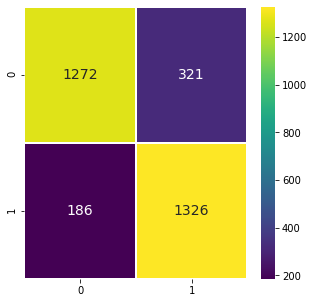

In [198]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_test_balanced,predictions_balanced), annot=True, fmt="d", linewidths=1, annot_kws={'size':14},cmap='viridis')